In [1]:
# ============================================================================
# AVİATOR MULTİPLİER PREDİCTİON MODEL - OPTİMİZED REAL-TİME VERSİON
# ============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import glob
import os
from datetime import datetime, timedelta
import time
import pickle
from collections import deque
import json
from pathlib import Path
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Using device: cpu


In [2]:
# ============================================================================
# 1. DATA MANAGER - LOADS AND PREPROCESSES DATA
# ============================================================================

class DataManager:
    """Manages data loading, preprocessing, and real-time updates."""
    
    def __init__(self, data_folder='data', min_multiplier=1.0):
        self.data_folder = data_folder
        self.min_multiplier = min_multiplier
        self.df = None
        self.historical_stats = {}
        
    def load_historical_data(self, csv_file):
        """Load and preprocess historical data."""
        print(f"Loading data from {csv_file}")
        df = pd.read_csv(csv_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Validate multipliers
        df['multiplier'] = pd.to_numeric(df['multiplier'], errors='coerce')
        df = df[df['multiplier'] >= self.min_multiplier]
        df = df.dropna().reset_index(drop=True)
        
        # Calculate historical statistics (for training)
        self._calculate_historical_stats(df)
        
        self.df = df
        print(f"✓ Loaded {len(df)} records")
        print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
        return df
    
    def _calculate_historical_stats(self, df):
        """Calculate statistics from historical data."""
        self.historical_stats = {
            'mean': df['multiplier'].mean(),
            'std': df['multiplier'].std(),
            'median': df['multiplier'].median(),
            'min': df['multiplier'].min(),
            'max': df['multiplier'].max(),
            'q25': df['multiplier'].quantile(0.25),
            'q75': df['multiplier'].quantile(0.75),
            'q90': df['multiplier'].quantile(0.90),
            'q95': df['multiplier'].quantile(0.95),
            'skew': df['multiplier'].skew(),
            'kurtosis': df['multiplier'].kurtosis()
        }


In [3]:
# ============================================================================
# 2. FEATURE ENGINEER - ENHANCED WITHOUT DATA LEAKAGE
# ============================================================================

class FeatureEngineer:
    """Enhanced feature engineering without data leakage."""
    
    def __init__(self, lookback=30):
        self.lookback = lookback
        self.feature_names = []
        
    def prepare_features(self, df, historical_stats=None):
        """Prepare features for training WITHOUT data leakage."""
        if len(df) < self.lookback + 1:
            return None, None
        
        df = df.copy()
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Extract time components
        df['hour'] = df['timestamp'].dt.hour
        df['minute'] = df['timestamp'].dt.minute
        df['second'] = df['timestamp'].dt.second
        df['time_of_day'] = df['hour'] * 3600 + df['minute'] * 60 + df['second']
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        
        # Calculate rolling statistics
        self._calculate_rolling_stats(df)
        
        features = []
        targets = []
        
        for i in range(self.lookback, len(df)):
            # Use only historical data up to current point
            historical_df = df.iloc[:i]
            current_window = df.iloc[i-self.lookback:i]
            
            # Calculate features using only historical data
            feature_row = self._compute_features(
                current_window, 
                historical_df,
                historical_stats,
                df.iloc[i-1] if i > 0 else None
            )
            
            if feature_row is not None:
                features.append(feature_row)
                targets.append(df['multiplier'].iloc[i])
        
        features_array = np.array(features)
        targets_array = np.array(targets)
        
        # Store feature names
        self.feature_names = self._get_feature_names()
        
        return features_array, targets_array
    
    def _calculate_rolling_stats(self, df):
        """Calculate rolling statistics."""
        # Rolling means
        for window in [3, 5, 10, 20]:
            df[f'rolling_mean_{window}'] = df['multiplier'].rolling(window=window, min_periods=1).mean()
        
        # Rolling std
        for window in [5, 10, 20]:
            df[f'rolling_std_{window}'] = df['multiplier'].rolling(window=window, min_periods=1).std()
        
        # EMA
        for span in [3, 5, 10, 20]:
            df[f'ema_{span}'] = df['multiplier'].ewm(span=span, adjust=False).mean()
        
        # Differences
        df['diff_1'] = df['multiplier'].diff(1)
        df['diff_2'] = df['multiplier'].diff(2)
        df['pct_change'] = df['multiplier'].pct_change()
        
        # Min/Max
        df['rolling_min_5'] = df['multiplier'].rolling(window=5, min_periods=1).min()
        df['rolling_max_5'] = df['multiplier'].rolling(window=5, min_periods=1).max()
    
    def _compute_features(self, window, historical_df, historical_stats, previous_row):
        """Compute features for a single window."""
        window_values = window['multiplier'].values
        
        # 1. Basic Statistics (5 features)
        mean_val = np.mean(window_values)
        std_val = np.std(window_values) if len(window_values) > 1 else 0
        min_val = np.min(window_values)
        max_val = np.max(window_values)
        median_val = np.median(window_values)
        
        # 2. Recent Values (3 features)
        last_1 = window_values[-1]
        last_2 = window_values[-2] if len(window_values) > 1 else last_1
        last_3 = window_values[-3] if len(window_values) > 2 else last_2
        
        # 3. Recent Averages (2 features)
        last_5_mean = np.mean(window_values[-5:]) if len(window_values) >= 5 else mean_val
        last_10_mean = np.mean(window_values[-10:]) if len(window_values) >= 10 else mean_val
        
        # 4. Percentiles (3 features)
        p10 = np.percentile(window_values, 10)
        p90 = np.percentile(window_values, 90)
        iqr = np.percentile(window_values, 75) - np.percentile(window_values, 25)
        
        # 5. Volatility (2 features)
        volatility_5 = np.std(window_values[-5:]) if len(window_values) >= 5 else std_val
        volatility_10 = np.std(window_values[-10:]) if len(window_values) >= 10 else std_val
        
        # 6. Trends (2 features)
        recent_5 = window_values[-5:] if len(window_values) >= 5 else window_values
        recent_10 = window_values[-10:] if len(window_values) >= 10 else window_values
        trend_5 = np.polyfit(range(len(recent_5)), recent_5, 1)[0] if len(recent_5) > 1 else 0
        trend_10 = np.polyfit(range(len(recent_10)), recent_10, 1)[0] if len(recent_10) > 1 else 0
        
        # 7. Patterns (3 features)
        high_ratio = np.sum(window_values > 2.0) / len(window_values)
        very_high_ratio = np.sum(window_values > 10.0) / len(window_values)
        low_ratio = np.sum(window_values < 1.5) / len(window_values)
        
        # 8. Momentum (3 features)
        momentum_1 = last_1 - last_2 if len(window_values) > 1 else 0
        momentum_2 = last_2 - last_3 if len(window_values) > 2 else 0
        acceleration = momentum_1 - momentum_2
        
        # 9. Rate of Change (2 features)
        roc_1 = (last_1 - last_2) / last_2 if len(window_values) > 1 and last_2 > 0 else 0
        roc_5 = (last_1 - window_values[-6]) / window_values[-6] if len(window_values) > 5 and window_values[-6] > 0 else 0
        
        # 10. Range Features (2 features)
        range_val = max_val - min_val
        range_ratio = range_val / mean_val if mean_val > 0 else 0
        
        # 11. Rolling Statistics (3 features)
        if previous_row is not None:
            rolling_mean_5 = previous_row['rolling_mean_5']
            rolling_std_5 = previous_row['rolling_std_5']
            ema_5 = previous_row['ema_5']
        else:
            rolling_mean_5 = rolling_std_5 = ema_5 = mean_val
        
        # 12. MA Ratios (2 features)
        ma_ratio_3_5 = (previous_row['rolling_mean_3'] / rolling_mean_5) if previous_row is not None and rolling_mean_5 > 0 else 1
        ema_ratio_3_5 = (previous_row['ema_3'] / ema_5) if previous_row is not None and ema_5 > 0 else 1
        
        # 13. Distances from MA (2 features)
        dist_from_ma5 = last_1 - rolling_mean_5
        dist_from_ema5 = last_1 - ema_5
        
        # 14. Z-scores (2 features)
        z_score_5 = (last_1 - rolling_mean_5) / rolling_std_5 if rolling_std_5 > 0 else 0
        z_score_10 = (last_1 - previous_row['rolling_mean_10']) / previous_row['rolling_std_10'] if previous_row is not None and previous_row['rolling_std_10'] > 0 else 0
        
        # 15. Historical Comparisons (3 features)
        if len(historical_df) > 0:
            hist_mean = historical_df['multiplier'].mean()
            hist_std = historical_df['multiplier'].std() if len(historical_df) > 1 else 0
            window_vs_hist = mean_val / hist_mean if hist_mean > 0 else 1
            z_score_hist = (last_1 - hist_mean) / hist_std if hist_std > 0 else 0
            percentile_hist = (historical_df['multiplier'] < last_1).sum() / len(historical_df)
        elif historical_stats:
            window_vs_hist = mean_val / historical_stats['mean'] if historical_stats['mean'] > 0 else 1
            z_score_hist = (last_1 - historical_stats['mean']) / historical_stats['std'] if historical_stats['std'] > 0 else 0
            percentile_hist = 0.5
        else:
            window_vs_hist = z_score_hist = percentile_hist = 0
        
        # 16. Time Features (3 features)
        current_time = window['timestamp'].iloc[-1]
        hour = window['hour'].iloc[-1]
        time_of_day = window['time_of_day'].iloc[-1]
        
        # 17. Time Differences (1 feature)
        if len(window) > 1:
            time_diff = (current_time - window['timestamp'].iloc[-2]).total_seconds()
        else:
            time_diff = 0
        
        # 18. Time Since Events (2 features)
        current_idx = len(historical_df)
        recent_highs = [j for j in range(max(0, current_idx-10), current_idx) 
                       if historical_df['multiplier'].iloc[j] > 5.0]
        time_since_high = (current_idx - recent_highs[-1]) if recent_highs else 20
        
        recent_lows = [j for j in range(max(0, current_idx-10), current_idx) 
                      if historical_df['multiplier'].iloc[j] < 1.5]
        time_since_low = (current_idx - recent_lows[-1]) if recent_lows else 20
        
        # 19. Autocorrelation (1 feature)
        if len(window_values) > 1:
            autocorr = np.corrcoef(window_values[:-1], window_values[1:])[0, 1]
            if np.isnan(autocorr):
                autocorr = 0
        else:
            autocorr = 0
        
        # 20. CV and Range Ratio (2 features)
        cv = std_val / mean_val if mean_val > 0 else 0
        
        # Assemble feature vector (35 features)
        feature_row = [
            # Basic stats
            mean_val, std_val, min_val, max_val, median_val,
            # Recent values
            last_1, last_2, last_3,
            # Recent averages
            last_5_mean, last_10_mean,
            # Percentiles
            p10, p90, iqr,
            # Volatility
            volatility_5, volatility_10,
            # Trends
            trend_5, trend_10,
            # Patterns
            high_ratio, very_high_ratio, low_ratio,
            # Momentum
            momentum_1, momentum_2, acceleration,
            # Rate of change
            roc_1, roc_5,
            # Range
            range_val, range_ratio,
            # Rolling stats
            rolling_mean_5, rolling_std_5, ema_5,
            # MA ratios
            ma_ratio_3_5, ema_ratio_3_5,
            # Distances
            dist_from_ma5, dist_from_ema5,
            # Z-scores
            z_score_5, z_score_10,
            # Historical comparisons
            window_vs_hist, z_score_hist, percentile_hist,
            # Time features
            hour, time_of_day, time_diff,
            # Time since events
            time_since_high, time_since_low,
            # Autocorrelation
            autocorr,
            # CV
            cv
        ]
        
        return feature_row
    
    def _get_feature_names(self):
        """Get names of all features."""
        return [
            'mean', 'std', 'min', 'max', 'median',
            'last_1', 'last_2', 'last_3',
            'last_5_mean', 'last_10_mean',
            'p10', 'p90', 'iqr',
            'volatility_5', 'volatility_10',
            'trend_5', 'trend_10',
            'high_ratio', 'very_high_ratio', 'low_ratio',
            'momentum_1', 'momentum_2', 'acceleration',
            'roc_1', 'roc_5',
            'range_val', 'range_ratio',
            'rolling_mean_5', 'rolling_std_5', 'ema_5',
            'ma_ratio_3_5', 'ema_ratio_3_5',
            'dist_from_ma5', 'dist_from_ema5',
            'z_score_5', 'z_score_10',
            'window_vs_hist', 'z_score_hist', 'percentile_hist',
            'hour', 'time_of_day', 'time_diff',
            'time_since_high', 'time_since_low',
            'autocorr', 'cv'
        ]

In [4]:
# ============================================================================
# 3. REAL-TIME FEATURE ENGINEER - INCREMENTAL COMPUTATION
# ============================================================================

class RealTimeFeatureEngineer:
    """Real-time feature engineering with incremental updates."""
    
    def __init__(self, lookback=30, historical_stats=None):
        self.lookback = lookback
        self.historical_stats = historical_stats
        
        # Buffers for incremental computation
        self.multiplier_buffer = deque(maxlen=lookback * 2)
        self.timestamp_buffer = deque(maxlen=lookback * 2)
        
        # Track rolling statistics
        self.rolling_means = {w: deque(maxlen=100) for w in [3, 5, 10, 20]}
        self.rolling_stds = {w: deque(maxlen=100) for w in [5, 10, 20]}
        self.emas = {span: deque(maxlen=100) for span in [3, 5, 10, 20]}
        
        # Initialize EMAs with None
        self.last_ema = {span: None for span in [3, 5, 10, 20]}
    
    def update(self, timestamp, multiplier):
        """Update buffers with new data point."""
        self.multiplier_buffer.append(multiplier)
        self.timestamp_buffer.append(timestamp)
        
        # Update rolling statistics incrementally
        self._update_stats(multiplier)
        
        return len(self.multiplier_buffer) >= self.lookback
    
    def _update_stats(self, new_value):
        """Update rolling statistics incrementally."""
        values = list(self.multiplier_buffer)
        
        # Update rolling means
        for window in [3, 5, 10, 20]:
            if len(values) >= window:
                window_vals = values[-window:]
                self.rolling_means[window].append(np.mean(window_vals))
        
        # Update rolling stds
        for window in [5, 10, 20]:
            if len(values) >= window:
                window_vals = values[-window:]
                self.rolling_stds[window].append(np.std(window_vals))
        
        # Update EMAs
        for span in [3, 5, 10, 20]:
            if self.last_ema[span] is None:
                self.last_ema[span] = new_value
            else:
                alpha = 2 / (span + 1)
                new_ema = alpha * new_value + (1 - alpha) * self.last_ema[span]
                self.last_ema[span] = new_ema
            self.emas[span].append(self.last_ema[span])
    
    def get_last_stats(self, window):
        """Get last calculated statistic for a given window."""
        if window in self.rolling_means and self.rolling_means[window]:
            return self.rolling_means[window][-1], \
                   self.rolling_stds.get(window, [0])[-1] if window in self.rolling_stds and self.rolling_stds[window] else 0
        return None, None
    
    def compute_features(self):
        """Compute features for current state."""
        if len(self.multiplier_buffer) < self.lookback:
            return None
        
        values = list(self.multiplier_buffer)[-self.lookback:]
        timestamps = list(self.timestamp_buffer)[-self.lookback:]
        
        # Create a mock dataframe for compatibility
        mock_df = pd.DataFrame({
            'timestamp': timestamps,
            'multiplier': values,
            'hour': [ts.hour for ts in timestamps],
            'time_of_day': [ts.hour * 3600 + ts.minute * 60 + ts.second for ts in timestamps]
        })
        
        # Get previous row stats
        prev_mean_5, prev_std_5 = self.get_last_stats(5)
        prev_mean_3, _ = self.get_last_stats(3)
        prev_mean_10, prev_std_10 = self.get_last_stats(10)
        
        # Mock previous row
        previous_row = None
        if prev_mean_5 is not None:
            previous_row = type('obj', (object,), {
                'rolling_mean_5': prev_mean_5,
                'rolling_std_5': prev_std_5,
                'rolling_mean_3': prev_mean_3,
                'rolling_mean_10': prev_mean_10,
                'rolling_std_10': prev_std_10,
                'ema_3': self.emas[3][-1] if self.emas[3] else prev_mean_3,
                'ema_5': self.emas[5][-1] if self.emas[5] else prev_mean_5
            })
        
        # Create historical dataframe (all data up to now)
        historical_values = list(self.multiplier_buffer)
        historical_df = pd.DataFrame({'multiplier': historical_values})
        
        # Use FeatureEngineer's compute logic
        feature_engineer = FeatureEngineer(lookback=self.lookback)
        features = feature_engineer._compute_features(
            mock_df, 
            historical_df,
            self.historical_stats,
            previous_row
        )
        
        return np.array(features) if features is not None else None
    
    def reset(self):
        """Reset all buffers."""
        self.multiplier_buffer.clear()
        self.timestamp_buffer.clear()
        for key in self.rolling_means:
            self.rolling_means[key].clear()
        for key in self.rolling_stds:
            self.rolling_stds[key].clear()
        for key in self.emas:
            self.emas[key].clear()
        self.last_ema = {span: None for span in [3, 5, 10, 20]}


In [5]:
# ============================================================================
# 4. LIGHTWEIGHT TRANSFORMER MODEL
# ============================================================================

class FastTransformerPredictor(nn.Module):
    """Lightweight transformer model for fast predictions."""
    
    def __init__(self, input_dim=35, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super(FastTransformerPredictor, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 100, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.fc1 = nn.Linear(d_model, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x)
        
        # Add positional encoding
        pos_enc = self.pos_encoder[:, :seq_len, :]
        x = x + pos_enc
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Use last timestep
        x = x[:, -1, :]
        
        # Output layers
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x.squeeze(-1)

In [6]:
# ============================================================================
# 5. DATASET AND TRAINER
# ============================================================================

class MultiplierDataset(Dataset):
    """Dataset for multiplier prediction."""
    
    def __init__(self, features, targets, seq_len=30):
        self.features = features
        self.targets = targets
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.features) - self.seq_len + 1
    
    def __getitem__(self, idx):
        # Get sequence
        feature_seq = self.features[idx:idx+self.seq_len]
        target = self.targets[idx+self.seq_len-1]
        
        return torch.FloatTensor(feature_seq), torch.FloatTensor([target])

class ModelTrainer:
    """Handles model training and evaluation."""
    
    def __init__(self, model, device, model_dir='models'):
        self.model = model
        self.device = device
        self.model_dir = model_dir
        os.makedirs(model_dir, exist_ok=True)
        
    def train(self, train_loader, val_loader, epochs=50, lr=0.001):
        """Train the model."""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=5, factor=0.5
        )
        
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        print("Starting training...")
        print("=" * 60)
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            for batch_features, batch_targets in train_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)
                
                optimizer.zero_grad()
                predictions = self.model(batch_features)
                loss = criterion(predictions, batch_targets.squeeze())
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, batch_targets in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_targets = batch_targets.to(self.device)
                    
                    predictions = self.model(batch_features)
                    loss = criterion(predictions, batch_targets.squeeze())
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            scheduler.step(avg_val_loss)
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.save_model("best_model.pth", {'epoch': epoch, 'val_loss': avg_val_loss})
            
            # Print progress
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - "
                      f"Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}")
        
        print("=" * 60)
        print(f"Training completed! Best Val Loss: {best_val_loss:.4f}")
        
        return train_losses, val_losses
    
    def evaluate(self, test_loader):
        """Evaluate model performance."""
        self.model.eval()
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)
                
                predictions = self.model(batch_features)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(batch_targets.cpu().numpy())
        
        predictions_array = np.array(all_predictions)
        targets_array = np.array(all_targets).flatten()
        
        # Calculate metrics
        mae = mean_absolute_error(targets_array, predictions_array)
        rmse = np.sqrt(mean_squared_error(targets_array, predictions_array))
        r2 = r2_score(targets_array, predictions_array)
        
        print(f"\nTest Results:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        return predictions_array, targets_array, {'mae': mae, 'rmse': rmse, 'r2': r2}
    
    def save_model(self, filename, metadata=None):
        """Save model and metadata."""
        model_path = os.path.join(self.model_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_params': {
                'input_dim': self.model.input_projection.in_features,
                'd_model': self.model.input_projection.out_features
            },
            'metadata': metadata
        }, model_path)
        print(f"Model saved to {model_path}")
    
    def load_model(self, filename):
        """Load model from file."""
        model_path = os.path.join(self.model_dir, filename)
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {model_path}")

In [7]:
# ============================================================================
# 6. REAL-TIME PREDICTOR
# ============================================================================

class RealTimePredictor:
    """Main class for real-time predictions."""
    
    def __init__(self, model_path, lookback=30, 
                 feature_scaler=None, target_scaler=None,
                 historical_stats=None):
        self.lookback = lookback
        self.device = device
        
        # Load model
        self.model = self._load_model(model_path)
        self.model.eval()
        
        # Scalers
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        
        # Feature engineer
        self.feature_engineer = RealTimeFeatureEngineer(
            lookback=lookback,
            historical_stats=historical_stats
        )
        
        # Tracking
        self.predictions = []
        self.actuals = []
        self.timestamps = []
        self.prediction_times = []
        
        # Cache
        self.prediction_cache = {}
        self.cache_size = 1000
    
    def _load_model(self, model_path):
        """Load model from checkpoint."""
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Extract model parameters
        model_params = checkpoint.get('model_params', {'input_dim': 35, 'd_model': 64})
        input_dim = model_params['input_dim']
        
        # Create model
        model = FastTransformerPredictor(input_dim=input_dim)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Loaded model from {model_path}")
        print(f"Input dimension: {input_dim}")
        
        return model
    
    def predict_next(self, timestamp, multiplier):
        """Make prediction for next multiplier."""
        start_time = time.time()
        
        # Check cache
        cache_key = f"{timestamp}_{multiplier:.2f}"
        if cache_key in self.prediction_cache:
            return self.prediction_cache[cache_key]
        
        # Update feature engineer
        has_data = self.feature_engineer.update(timestamp, multiplier)
        
        if not has_data:
            return None
        
        # Compute features
        features = self.feature_engineer.compute_features()
        
        if features is None:
            return None
        
        # Scale features
        if self.feature_scaler is not None:
            features_scaled = self.feature_scaler.transform([features])
        else:
            features_scaled = [features]
        
        # Convert to tensor
        features_tensor = torch.FloatTensor(features_scaled).unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            prediction_scaled = self.model(features_tensor).item()
        
        # Inverse transform
        if self.target_scaler is not None:
            prediction = self.target_scaler.inverse_transform([[prediction_scaled]])[0][0]
        else:
            prediction = prediction_scaled
        
        # Track time
        pred_time = time.time() - start_time
        self.prediction_times.append(pred_time)
        
        # Update cache
        if len(self.prediction_cache) >= self.cache_size:
            self.prediction_cache.pop(next(iter(self.prediction_cache)))
        
        self.prediction_cache[cache_key] = prediction
        
        # Store prediction
        self.predictions.append(prediction)
        self.timestamps.append(timestamp)
        
        return prediction
    
    def compare_with_actual(self, timestamp, actual_multiplier):
        """Compare latest prediction with actual value."""
        if len(self.predictions) == 0:
            return None
        
        latest_prediction = self.predictions[-1]
        latest_timestamp = self.timestamps[-1]
        
        # Check time difference
        time_diff = abs((timestamp - latest_timestamp).total_seconds())
        
        if time_diff > 30:  # 30 seconds tolerance
            print(f"Warning: Time difference ({time_diff:.1f}s) too large")
            return None
        
        # Calculate error
        error = actual_multiplier - latest_prediction
        percentage_error = (abs(error) / actual_multiplier) * 100 if actual_multiplier > 0 else 0
        
        # Store actual
        self.actuals.append(actual_multiplier)
        
        return {
            'timestamp': timestamp,
            'prediction': latest_prediction,
            'actual': actual_multiplier,
            'error': error,
            'absolute_error': abs(error),
            'percentage_error': percentage_error,
            'time_diff': time_diff
        }
    
    def get_performance_stats(self):
        """Calculate performance statistics."""
        if len(self.actuals) == 0:
            return None
        
        # Align arrays
        min_len = min(len(self.actuals), len(self.predictions))
        actuals_array = np.array(self.actuals[:min_len])
        predictions_array = np.array(self.predictions[:min_len])
        
        # Calculate metrics
        mae = mean_absolute_error(actuals_array, predictions_array)
        rmse = np.sqrt(mean_squared_error(actuals_array, predictions_array))
        r2 = r2_score(actuals_array, predictions_array)
        
        # Accuracy within thresholds
        thresholds = [0.1, 0.2, 0.5, 1.0]
        accuracy_stats = {}
        for threshold in thresholds:
            within = np.sum(np.abs(actuals_array - predictions_array) <= threshold) / min_len
            accuracy_stats[f'accuracy_within_{threshold}'] = within
        
        # Prediction time
        avg_pred_time = np.mean(self.prediction_times) * 1000 if self.prediction_times else 0
        
        return {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'n_predictions': min_len,
            'avg_prediction_time_ms': avg_pred_time,
            **accuracy_stats
        }
    
    def save_results(self, filename='predictions_results.csv'):
        """Save predictions and actuals to CSV."""
        if len(self.actuals) == 0:
            print("No actuals to save")
            return None
        
        min_len = min(len(self.actuals), len(self.timestamps), len(self.predictions))
        
        data = {
            'timestamp': self.timestamps[:min_len],
            'prediction': self.predictions[:min_len],
            'actual': self.actuals[:min_len],
            'error': [a - p for a, p in zip(self.actuals[:min_len], self.predictions[:min_len])]
        }
        
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")
        
        return df

In [8]:
# ============================================================================
# 7. MAIN TRAINING PIPELINE
# ============================================================================

def train_model(csv_file_path, lookback=30, test_size=0.2, 
                batch_size=64, epochs=50):
    """Main training pipeline."""
    
    print("=" * 60)
    print("AVIATOR MULTIPLIER PREDICTION MODEL TRAINING")
    print("=" * 60)
    
    # 1. Load data
    print("\n1. Loading data...")
    data_manager = DataManager()
    df = data_manager.load_historical_data(csv_file_path)
    
    # Use recent data
    recent_threshold = pd.to_datetime('2025-12-12')
    df = df[df['timestamp'] > recent_threshold]
    print(f"Using {len(df)} recent records")
    
    # 2. Prepare features
    print("\n2. Preparing features...")
    feature_engineer = FeatureEngineer(lookback=lookback)
    features, targets = feature_engineer.prepare_features(
        df, data_manager.historical_stats
    )
    
    if features is None:
        print("Not enough data for training")
        return None
    
    print(f"Features shape: {features.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Number of features: {features.shape[1]}")
    
    # 3. Split data
    print("\n3. Splitting data...")
    split_idx = int(len(features) * (1 - test_size))
    
    train_features = features[:split_idx]
    train_targets = targets[:split_idx]
    test_features = features[split_idx:]
    test_targets = targets[split_idx:]
    
    print(f"Training samples: {len(train_features)}")
    print(f"Test samples: {len(test_features)}")
    
    # 4. Scale data
    print("\n4. Scaling data...")
    feature_scaler = RobustScaler()
    target_scaler = RobustScaler()
    
    train_features_scaled = feature_scaler.fit_transform(train_features)
    test_features_scaled = feature_scaler.transform(test_features)
    
    train_targets_scaled = target_scaler.fit_transform(
        train_targets.reshape(-1, 1)
    ).flatten()
    test_targets_scaled = target_scaler.transform(
        test_targets.reshape(-1, 1)
    ).flatten()
    
    # Save scalers
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(feature_scaler, f)
    with open('target_scaler.pkl', 'wb') as f:
        pickle.dump(target_scaler, f)
    
    # Save historical stats
    with open('historical_stats.json', 'w') as f:
        json.dump(data_manager.historical_stats, f)
    
    print("Scalers and stats saved")
    
    # 5. Create datasets
    print("\n5. Creating datasets...")
    train_dataset = MultiplierDataset(
        train_features_scaled, train_targets_scaled, seq_len=lookback
    )
    test_dataset = MultiplierDataset(
        test_features_scaled, test_targets_scaled, seq_len=lookback
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    # 6. Create model
    print("\n6. Creating model...")
    input_dim = features.shape[1]
    model = FastTransformerPredictor(input_dim=input_dim).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # 7. Train model
    print("\n7. Training model...")
    trainer = ModelTrainer(model, device)
    train_losses, val_losses = trainer.train(
        train_loader, test_loader, epochs=epochs
    )
    
    # 8. Evaluate
    print("\n8. Evaluating model...")
    predictions, actuals, metrics = trainer.evaluate(test_loader)
    
    # 9. Plot results
    print("\n9. Plotting results...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Training history
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Predictions vs Actuals
    axes[0, 1].scatter(actuals, predictions, alpha=0.6, s=20)
    axes[0, 1].plot([actuals.min(), actuals.max()], 
                    [actuals.min(), actuals.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Multiplier')
    axes[0, 1].set_ylabel('Predicted Multiplier')
    axes[0, 1].set_title('Predictions vs Actuals')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Error distribution
    errors = predictions - actuals
    axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Error Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Sample time series
    sample_size = min(50, len(predictions))
    axes[1, 1].plot(range(sample_size), actuals[:sample_size], 
                    'b-', label='Actual', linewidth=2, marker='o', markersize=4)
    axes[1, 1].plot(range(sample_size), predictions[:sample_size], 
                    'r--', label='Predicted', linewidth=2, marker='s', markersize=4)
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Multiplier')
    axes[1, 1].set_title('Sample Predictions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 10. Save final model
    print("\n10. Saving final model...")
    trainer.save_model("final_model.pth", {
        'lookback': lookback,
        'input_dim': input_dim,
        'metrics': metrics,
        'feature_names': feature_engineer.feature_names
    })
    
    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)
    
    return {
        'model': model,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'historical_stats': data_manager.historical_stats,
        'feature_engineer': feature_engineer,
        'metrics': metrics
    }

In [9]:
# ============================================================================
# 8. REAL-TIME MONITORING
# ============================================================================

class CSVMonitor:
    """Monitors CSV file for new data."""
    
    def __init__(self, csv_path, predictor, update_interval=1.0):
        self.csv_path = csv_path
        self.predictor = predictor
        self.update_interval = update_interval
        self.last_position = 0
        self.running = False
        
        # Load existing data
        self._load_existing()
    
    def _load_existing(self):
        """Load existing data to warm up predictor."""
        try:
            df = pd.read_csv(self.csv_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            print(f"Warming up with {len(df)} existing records...")
            
            for _, row in df.iterrows():
                self.predictor.predict_next(row['timestamp'], row['multiplier'])
            
            self.last_position = os.path.getsize(self.csv_path)
            
        except Exception as e:
            print(f"Warning: Could not load existing data: {e}")
    
    def start(self):
        """Start monitoring."""
        print(f"\nStarting monitoring of {self.csv_path}")
        print("Press Ctrl+C to stop\n")
        
        self.running = True
        
        try:
            while self.running:
                self._check_new_data()
                time.sleep(self.update_interval)
        except KeyboardInterrupt:
            self.stop()
    
    def _check_new_data(self):
        """Check for new data in CSV."""
        try:
            current_size = os.path.getsize(self.csv_path)
            
            if current_size > self.last_position:
                with open(self.csv_path, 'r') as f:
                    f.seek(self.last_position)
                    new_lines = f.readlines()
                    self.last_position = f.tell()
                
                if new_lines:
                    # Skip header
                    if self.last_position == len(new_lines[0]):
                        new_lines = new_lines[1:]
                    
                    for line in new_lines:
                        self._process_line(line.strip())
        
        except Exception as e:
            print(f"Error reading CSV: {e}")
    
    def _process_line(self, line):
        """Process a single CSV line."""
        try:
            parts = line.split(',')
            if len(parts) >= 2:
                timestamp = pd.to_datetime(parts[0])
                multiplier = float(parts[1])
                
                # Make prediction
                prediction = self.predictor.predict_next(timestamp, multiplier)
                
                if prediction is not None:
                    print(f"[{timestamp}] Predicted: {prediction:.3f}")
                    
                    # In real scenario, compare with next actual
                    # Here we'll simulate by using current as "next"
                    comparison = self.predictor.compare_with_actual(
                        timestamp + timedelta(seconds=10),  # Simulate 10s later
                        multiplier
                    )
                    
                    if comparison:
                        print(f"  Actual: {comparison['actual']:.3f}, "
                              f"Error: {comparison['error']:.3f}")
        
        except Exception as e:
            print(f"Error processing line: {e}")
    
    def stop(self):
        """Stop monitoring and save results."""
        self.running = False
        self.predictor.save_results()
        
        stats = self.predictor.get_performance_stats()
        if stats:
            print("\n" + "=" * 60)
            print("FINAL STATISTICS")
            print("=" * 60)
            for key, value in stats.items():
                if isinstance(value, float):
                    print(f"{key}: {value:.4f}")
                else:
                    print(f"{key}: {value}")

In [10]:
# ============================================================================
# 9. MAIN EXECUTION FUNCTION
# ============================================================================

def main():
    """Main execution function."""
    
    # Configuration
    CSV_FILE = "../data/aviator_payouts_global.csv"
    LOOKBACK = 30
    BATCH_SIZE = 64
    EPOCHS = 50
    TEST_SIZE = 0.2
    
    print("=" * 80)
    print("AVIATOR MULTIPLIER PREDICTION - COMPLETE SYSTEM")
    print("=" * 80)
    
    # Part 1: Training
    print("\nPART 1: MODEL TRAINING")
    print("-" * 40)
    
    training_results = train_model(
        csv_file_path=CSV_FILE,
        lookback=LOOKBACK,
        test_size=TEST_SIZE,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )
    
    if training_results is None:
        print("Training failed. Exiting.")
        return
    
    # Part 2: Real-time Setup
    print("\n\nPART 2: REAL-TIME SETUP")
    print("-" * 40)
    
    # Load scalers
    with open('feature_scaler.pkl', 'rb') as f:
        feature_scaler = pickle.load(f)
    with open('target_scaler.pkl', 'rb') as f:
        target_scaler = pickle.load(f)
    with open('historical_stats.json', 'r') as f:
        historical_stats = json.load(f)
    
    # Create real-time predictor
    predictor = RealTimePredictor(
        model_path='models/final_model.pth',
        lookback=LOOKBACK,
        feature_scaler=feature_scaler,
        target_scaler=target_scaler,
        historical_stats=historical_stats
    )
    
    # Test prediction speed
    print("\nTesting prediction speed...")
    test_times = []
    
    for i in range(10):
        timestamp = pd.Timestamp.now() + timedelta(seconds=i)
        multiplier = 2.0 + np.random.random() * 3.0
        
        start = time.time()
        pred = predictor.predict_next(timestamp, multiplier)
        test_times.append(time.time() - start)
    
    avg_time = np.mean(test_times) * 1000
    print(f"Average prediction time: {avg_time:.1f}ms")
    
    if avg_time < 2000:
        print("✓ Speed requirement met (<2000ms)")
    else:
        print("⚠ Speed needs improvement")
    
    # Part 3: Simulation
    print("\n\nPART 3: SIMULATION WITH HISTORICAL DATA")
    print("-" * 40)
    
    # Load data for simulation
    df = pd.read_csv(CSV_FILE)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    recent_data = df[df['timestamp'] > pd.to_datetime('2025-12-12')].tail(100)
    
    print(f"Simulating {len(recent_data)} predictions...")
    
    for idx, row in recent_data.iterrows():
        # Add small delay to simulate real-time
        time.sleep(0.05)
        
        # Make prediction
        prediction = predictor.predict_next(row['timestamp'], row['multiplier'])
        
        if prediction is not None and idx % 10 == 0:
            print(f"[{row['timestamp'].strftime('%H:%M:%S')}] "
                  f"Multiplier: {row['multiplier']:.2f}, "
                  f"Predicted: {prediction:.2f}")
    
    # Part 4: Results
    print("\n\nPART 4: RESULTS")
    print("-" * 40)
    
    stats = predictor.get_performance_stats()
    if stats:
        print(f"\nReal-time Performance:")
        print(f"Predictions made: {stats['n_predictions']}")
        print(f"MAE: {stats['mae']:.4f}")
        print(f"RMSE: {stats['rmse']:.4f}")
        print(f"R² Score: {stats['r2']:.4f}")
        print(f"Avg prediction time: {stats['avg_prediction_time_ms']:.1f}ms")
        
        print(f"\nAccuracy:")
        for threshold in [0.1, 0.2, 0.5, 1.0]:
            key = f'accuracy_within_{threshold}'
            if key in stats:
                print(f"  Within ±{threshold}: {stats[key]*100:.1f}%")
    
    # Save results
    predictor.save_results()
    
    # Plot real-time results
    if stats and stats['n_predictions'] > 0:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Predictions vs Actuals
        actuals = np.array(predictor.actuals)
        predictions = np.array(predictor.predictions[:len(actuals)])
        
        axes[0].scatter(actuals, predictions, alpha=0.6)
        axes[0].plot([actuals.min(), actuals.max()], 
                     [actuals.min(), actuals.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Multiplier')
        axes[0].set_ylabel('Predicted Multiplier')
        axes[0].set_title('Real-time: Predictions vs Actuals')
        axes[0].grid(True, alpha=0.3)
        
        # Error progression
        errors = predictions - actuals
        axes[1].plot(errors, 'b-', alpha=0.7, linewidth=2)
        axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[1].fill_between(range(len(errors)), errors, 0, alpha=0.3)
        axes[1].set_xlabel('Prediction Number')
        axes[1].set_ylabel('Prediction Error')
        axes[1].set_title('Error Progression Over Time')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('realtime_performance.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("\n" + "=" * 80)
    print("SYSTEM READY FOR DEPLOYMENT!")
    print("=" * 80)
    
    # Return predictor for further use
    return predictor

In [11]:
# ============================================================================
# 10. DEPLOYMENT READY CELL
# ============================================================================

def deploy_real_time_system():
    """Deploy the complete real-time prediction system."""
    
    print("Deploying Real-time Prediction System...")
    print("-" * 40)
    
    # Configuration
    MODEL_PATH = "models/final_model.pth"
    FEATURE_SCALER_PATH = "feature_scaler.pkl"
    TARGET_SCALER_PATH = "target_scaler.pkl"
    HISTORICAL_STATS_PATH = "historical_stats.json"
    CSV_TO_MONITOR = "data/aviator_payouts_global.csv"
    
    # Load components
    print("1. Loading components...")
    
    # Load scalers
    try:
        with open(FEATURE_SCALER_PATH, 'rb') as f:
            feature_scaler = pickle.load(f)
        with open(TARGET_SCALER_PATH, 'rb') as f:
            target_scaler = pickle.load(f)
        with open(HISTORICAL_STATS_PATH, 'r') as f:
            historical_stats = json.load(f)
        
        print("✓ Components loaded successfully")
    except Exception as e:
        print(f"✗ Error loading components: {e}")
        return None
    
    # Create predictor
    print("2. Initializing predictor...")
    try:
        predictor = RealTimePredictor(
            model_path=MODEL_PATH,
            lookback=30,
            feature_scaler=feature_scaler,
            target_scaler=target_scaler,
            historical_stats=historical_stats
        )
        print("✓ Predictor initialized")
    except Exception as e:
        print(f"✗ Error initializing predictor: {e}")
        return None
    
    # Create monitor
    print("3. Setting up monitor...")
    try:
        monitor = CSVMonitor(
            csv_path=CSV_TO_MONITOR,
            predictor=predictor,
            update_interval=1.0
        )
        print("✓ Monitor ready")
    except Exception as e:
        print(f"✗ Error setting up monitor: {e}")
        return None
    
    print("\n" + "=" * 60)
    print("DEPLOYMENT SUCCESSFUL!")
    print("=" * 60)
    print("\nSystem is ready to monitor the CSV file.")
    print("Predictions will be made in real-time as new data arrives.")
    print("\nTo start monitoring, run: monitor.start()")
    
    return predictor, monitor

AVIATOR MULTIPLIER PREDICTION - COMPLETE SYSTEM

PART 1: MODEL TRAINING
----------------------------------------
AVIATOR MULTIPLIER PREDICTION MODEL TRAINING

1. Loading data...
Loading data from ../data/aviator_payouts_global.csv
✓ Loaded 8793 records
  Date range: 2025-12-10 19:32:35 to 2025-12-14 04:27:17
Using 5037 recent records

2. Preparing features...
Features shape: (5007, 46)
Targets shape: (5007,)
Number of features: 46

3. Splitting data...
Training samples: 4005
Test samples: 1002

4. Scaling data...
Scalers and stats saved

5. Creating datasets...
Train batches: 63
Test batches: 16

6. Creating model...
Model parameters: 82,625

7. Training model...
Starting training...
Model saved to models/best_model.pth
Model saved to models/best_model.pth
Model saved to models/best_model.pth
Epoch [5/50] - Train Loss: 1502.5049, Val Loss: 904.1787
Model saved to models/best_model.pth
Epoch [10/50] - Train Loss: 1502.2967, Val Loss: 903.5118
Epoch [15/50] - Train Loss: 1494.2535, Val L

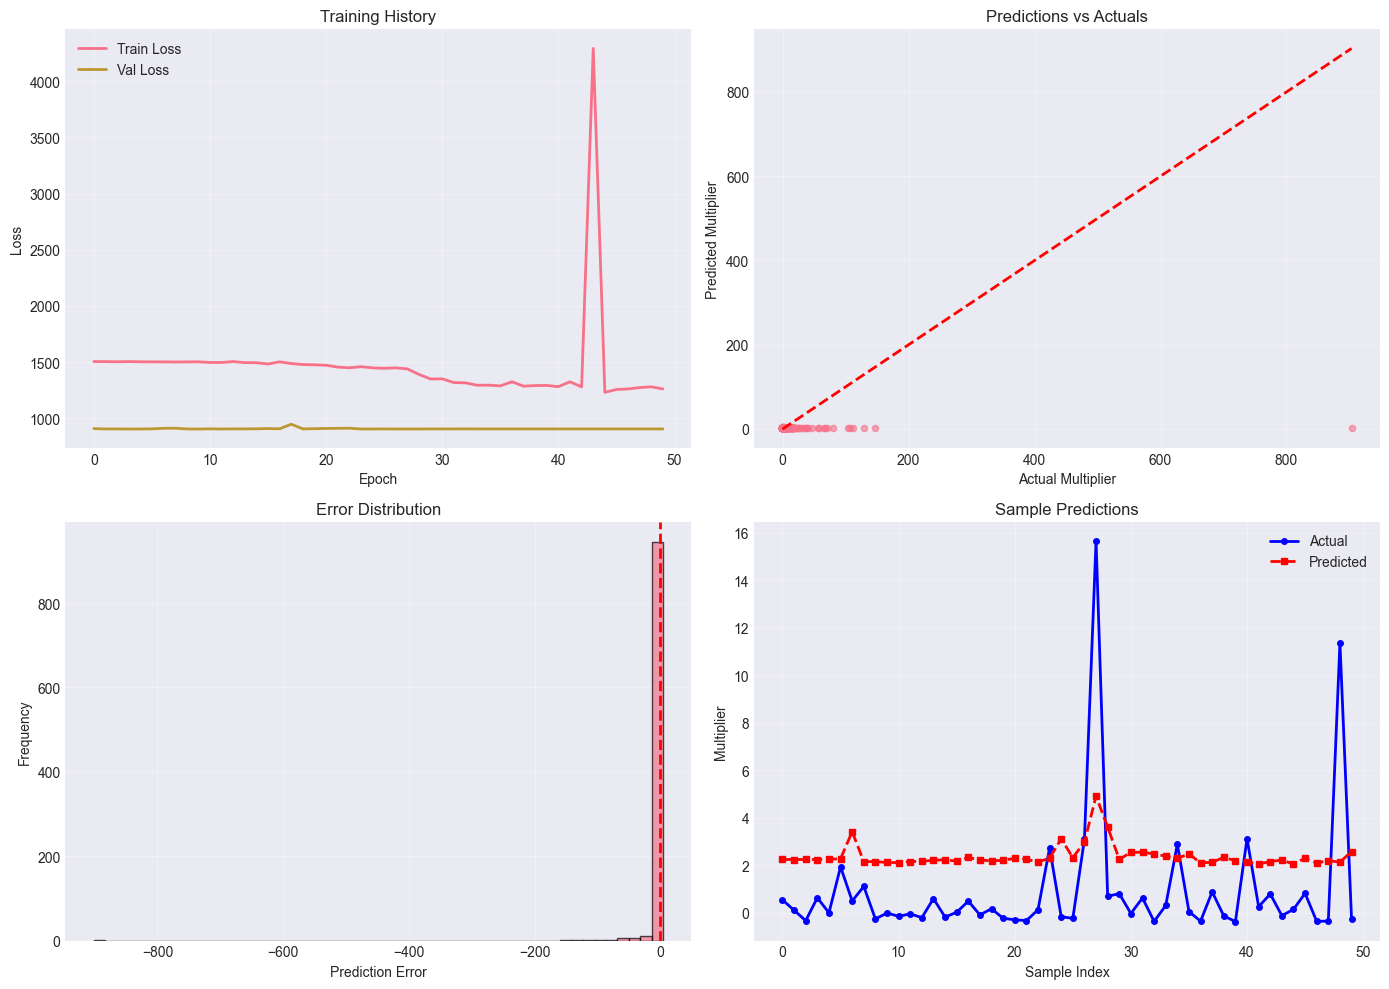


10. Saving final model...
Model saved to models/final_model.pth

TRAINING COMPLETE!


PART 2: REAL-TIME SETUP
----------------------------------------
Loaded model from models/final_model.pth
Input dimension: 46

Testing prediction speed...
Average prediction time: 0.1ms
✓ Speed requirement met (<2000ms)


PART 3: SIMULATION WITH HISTORICAL DATA
----------------------------------------
Simulating 100 predictions...


TypeError: type 'obj' is not subscriptable

In [12]:
# ============================================================================
# EXECUTE THE SYSTEM
# ============================================================================

if __name__ == "__main__":
    # Run the complete system
    predictor = main()
    
    # For deployment:
    # predictor, monitor = deploy_real_time_system()
    # monitor.start()